In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime 
from IPython.display import display, HTML, clear_output
import gc
import seaborn as sns
from scipy.stats import normaltest, boxcox, probplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from random import shuffle
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import f1_score, balanced_accuracy_score

Using TensorFlow backend.


In [2]:
r'''
dataset2019: all sumo data with ocupation (requested in sumo office)
'''

dataset2019_path = r'C:\Users\ing_l\Tesis grado\Data\dataset_2019.csv'

In [3]:
dataset2019 = pd.read_csv(dataset2019_path)[['id_cuadra', 'direccion', 'fecha', 'tiempo', 'operacion', 'ocupacion', 'latitud', 'longitud']]
dataset2019['dia de la semana'] = -1
dataset2019.columns.names = ['dataset2019']

In [4]:
def correct_type(row):
    '''
    Corrects the dtype of fecha, tiempo and ocupación on the df
    '''
    row['fecha'] = pd.to_datetime(row['fecha'], dayfirst=True).date()
    row['tiempo'] = pd.to_datetime(row['tiempo']).time()
    row['ocupacion'] = int(row['ocupacion'])
    row['dia de la semana'] = row['fecha'].weekday()
    return row

print('Working on dataset2019...')
dataset2019 = dataset2019.apply(correct_type, axis=1).sort_values(by=['fecha', 'tiempo'])
clear_output()

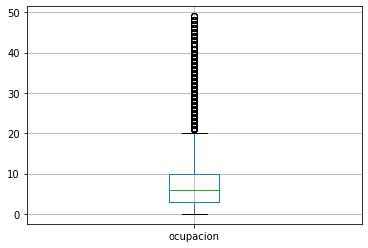

In [5]:
dataset2019['porcentaje ocupacion'] = 0
max_without_outliers = dataset2019.boxplot(column='ocupacion', return_type='dict')['whiskers'][1].get_ydata()[1]

grade_1 = dataset2019['ocupacion'] <= (max_without_outliers * 1/4)
grade_2 = (~grade_1) & (dataset2019['ocupacion'] <= (max_without_outliers * 2/4))
grade_3 = (~grade_1) & (~grade_2) & (dataset2019['ocupacion'] <= (max_without_outliers * 3/4))
grade_4 = (~grade_1) & (~grade_2) & (~grade_3) & (dataset2019['ocupacion'] <= (max_without_outliers))
grade_5 = (~grade_1) & (~grade_2) & (~grade_3) & (~grade_4)

dataset2019.loc[grade_1, 'porcentaje ocupacion'] = 0
dataset2019.loc[grade_2, 'porcentaje ocupacion'] = 1
dataset2019.loc[grade_3, 'porcentaje ocupacion'] = 2
dataset2019.loc[grade_4, 'porcentaje ocupacion'] = 3
dataset2019.loc[grade_5, 'porcentaje ocupacion'] = 4

In [6]:
dataset2019['mes'] = dataset2019['fecha'].apply(lambda x: x.month)
dataset2019['hora'] = dataset2019['tiempo'].apply(lambda x: x.hour)

In [53]:
dataset2019_copy = dataset2019.copy()

In [43]:
dataset2019

dataset2019,id_cuadra,direccion,fecha,tiempo,operacion,ocupacion,latitud,longitud,dia de la semana,porcentaje ocupacion,mes,hora
0,16,Belgrano 660,2019-01-01,10:55:00,0,0,-37.328838,-59.134455,1,0,1,10
7,1,General Pinto 545,2019-01-01,15:12:00,1,1,-37.327782,-59.136657,1,0,1,15
9,65,Rodriguez 348,2019-01-01,15:13:00,1,1,-37.329387,-59.134833,1,0,1,15
8,1,General Pinto 545,2019-01-01,15:15:00,0,0,-37.327782,-59.136657,1,0,1,15
10,65,Rodriguez 348,2019-01-01,16:22:00,0,0,-37.329387,-59.134833,1,0,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...
2957257,18,Sarmiento 543,2019-12-31,19:45:00,1,4,-0.000000,-0.000000,1,0,12,19
2957258,18,Sarmiento 543,2019-12-31,19:46:00,0,3,-0.000000,-0.000000,1,0,12,19
2956381,24,Belgrano 364,2019-12-31,19:53:00,1,1,-37.330077,-59.138438,1,0,12,19
2956511,60,Chacabuco 357,2019-12-31,20:08:00,0,0,-37.330203,-59.137003,1,0,12,20


In [7]:
def print_balanced_classes(df):
    d = df.copy()
    d = d.groupby(by='operacion').count()[['id_cuadra']]
    d.rename(columns={'id_cuadra': 'Cantidad datos'}, inplace=True)
    if pow(pow(d.iloc[0].values - d.iloc[1].values, 2), 0.5) > (len(df) * 0.4):
        print('Clases no balanceadas.')
    else:
        print('Clases balanceadas.')
    display(d)
    
print_balanced_classes(dataset2019)

Clases balanceadas.


dataset2019,Cantidad datos
operacion,
0,1477989
1,1479553


## Preparando input y output

In [37]:
input_features = ['id_cuadra', 'mes', 'dia de la semana', 'hora', 'ocupacion', 'porcentaje ocupacion']
output_features = ['operacion']

In [52]:
inputs = pd.DataFrame(columns=input_features)
outputs = pd.DataFrame(columns=output_features)

for street in dataset2019['id_cuadra'].drop_duplicates().sort_values():
    data_street = dataset2019.loc[dataset2019['id_cuadra'] == street]
    
    clear_output()
    print('Street:', street)
    
    for date in data_street['fecha'].drop_duplicates():
        data = data_street.loc[data_street['fecha'] == date]
        
        inputs = inputs.append(data[input_features][:-1]) 
        outputs = outputs.append(data[output_features][1:]) 

display(inputs, outputs)

Street: 190


dataset2019,id_cuadra,mes,dia de la semana,hora,ocupacion,porcentaje ocupacion
1849,0,1,2,9,1,0
1850,0,1,2,9,2,0
1851,0,1,2,9,3,0
1852,0,1,2,9,2,0
1853,0,1,2,9,1,0
...,...,...,...,...,...,...
2696276,190,11,3,10,1,0
2725920,190,12,0,11,1,0
2784938,190,12,0,8,0,0
2784939,190,12,0,10,1,0


dataset2019,operacion
1850,1
1851,1
1852,0
1853,0
1854,1
...,...
2696277,0
2725921,0
2784939,1
2784940,0


In [54]:
#inp = inputs.copy()
#outp = outputs.copy()

In [59]:
inputs = inp.copy().reset_index(drop=True)
outputs = outp.copy().reset_index(drop=True)

In [60]:
inputs['targets'] = outputs

In [61]:
inputs

dataset2019,id_cuadra,mes,dia de la semana,hora,ocupacion,porcentaje ocupacion,targets
0,0,1,2,9,1,0,1
1,0,1,2,9,2,0,1
2,0,1,2,9,3,0,0
3,0,1,2,9,2,0,0
4,0,1,2,9,1,0,1
...,...,...,...,...,...,...,...
2927765,190,11,3,10,1,0,0
2927766,190,12,0,11,1,0,0
2927767,190,12,0,8,0,0,1
2927768,190,12,0,10,1,0,0


# Outliers!

In [22]:
with_outliers = False

## Naive bayes classifier

###  Modelo separado por calle y hora!

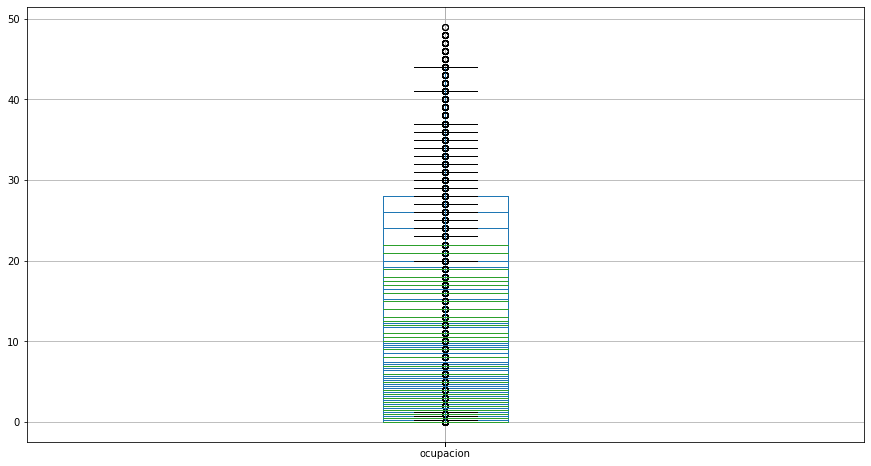

In [23]:
total_hours_in_a_day = 24

acc = np.ndarray((len(dataset2019['id_cuadra'].drop_duplicates())+1, total_hours_in_a_day))
acc.fill(-1)

full_conf_mat =  np.zeros((total_hours_in_a_day, 2, 2))
index = 0

for i in dataset2019['id_cuadra'].drop_duplicates():
    naive_bayes_data_cuadra = dataset2019.loc[dataset2019['id_cuadra'] == i].copy()
    index+=1
    clear_output()
    print('Indice:', index)

    for h in range(total_hours_in_a_day):

        naive_bayes_data_hora = naive_bayes_data_cuadra.loc[naive_bayes_data_cuadra['hora'] == h]
                
        if len(naive_bayes_data_hora) > 10: #10 datos minimo para entrenar
            if not with_outliers:
                max_without_outliers = naive_bayes_data_hora.boxplot(column='ocupacion', return_type='dict')['whiskers'][1].get_ydata()[1]
                naive_bayes_data_hora = naive_bayes_data_hora.loc[naive_bayes_data_hora['ocupacion'] <= max_without_outliers]            
            
            data = naive_bayes_data_hora[['mes', 'dia de la semana', 'ocupacion', 'porcentaje ocupacion', 'operacion']]
            #x = data[['mes', 'dia de la semana', 'porcentaje ocupacion']].to_numpy()[:-1]
            x = data[['porcentaje ocupacion']].to_numpy()[:-1]
            y = data['operacion'].to_numpy()[1:]

            if (sum(y == 0) > 2) & (sum(y == 1) > 2):
                x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, stratify=y)

                model = MultinomialNB()

                model.fit(x_train, y_train)

                predicts = model.predict(x_test)

                acc[index][h] = balanced_accuracy_score(y_test, predicts)

                full_conf_mat[h] += confusion_matrix(y_test, predicts)

clear_output()
acc = acc[1:]

In [24]:
acc[0]

array([-1. , -1. , -1. , -1. , -1. , -1. ,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5])

In [25]:
acc_per_hour = np.zeros(total_hours_in_a_day)
zeros_per_hour = np.zeros(total_hours_in_a_day)
for i in range(total_hours_in_a_day):
    acc_in_i = np.array([x[i] for x in acc])
    zeros = acc_in_i[acc_in_i == 0.]
    acc_in_i = acc_in_i[acc_in_i > 0]
    if len(acc_in_i) > 0:
        acc_per_hour[i] = sum(acc_in_i) / len(acc_in_i)
    else:
        acc_per_hour[i] = -1
    zeros_per_hour[i] = len(zeros)

# AHORA VER QUE HORARIOS SON LOS DE PEOR PREDICCION

### Los zeros representan cuando el predictor erro copletamente con alguna de las salidas (ya que ambas son igual de importantes)
#### El -1 esta para saber cuando la probabilidad de acertar es 0 (es uno por calle a lo sumo)
#### Recordar que utilice G-Mean, por lo que los valores de la prediccion no son accuracy, sino que porcentajes de los valores verdades son verdaderos y que porcentaje de los qeu predigo falsos son falsos.

## Esto pasaba en G-mean (cuando ambas salidas son igual de importantes) y en F1 (Cuando las positivas son mas importantes). Ahora que uso balanced accuracy no pasa esto 

In [26]:
acc_prob = pd.DataFrame([acc_per_hour, zeros_per_hour]).T.rename(columns={0: 'p', 1:'zeros'})
acc_prob

,p,zeros
0,0.5,0.0
1,0.5,0.0
2,0.5,0.0
3,0.5,0.0
4,0.5,0.0
5,0.5,0.0
6,0.5,0.0
7,0.5,0.0
8,0.5,0.0
9,0.5,0.0


In [27]:
hour = 10
print('Para la hora:', hour)
print('')
print(acc_prob.iloc[hour])
print(full_conf_mat[hour])
print('')
print('')
without_none = acc_prob.loc[acc_prob['p'] > -1, 'p'].reset_index(drop=True)
print('Total accuracy:  ', sum(without_none) / len(without_none))

Para la hora: 10

p        0.5
zeros    0.0
Name: 10, dtype: float64
[[1.1000e+01 4.5501e+04]
 [9.0000e+00 6.9984e+04]]


Total accuracy:   0.5


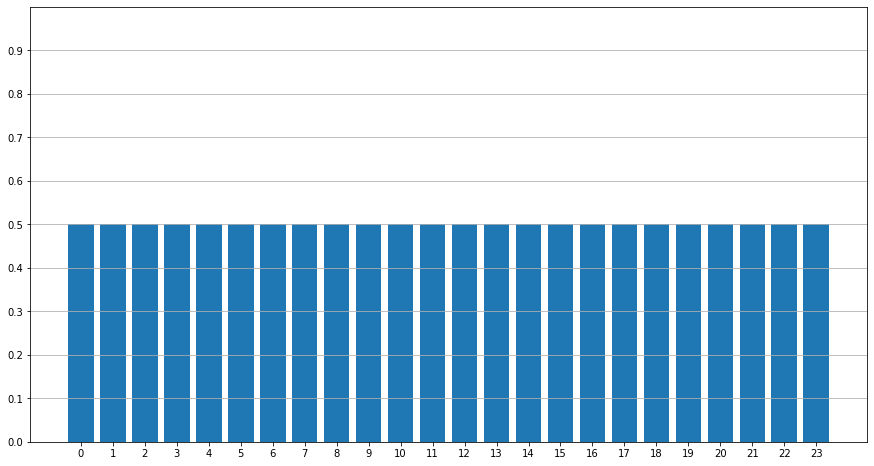

In [28]:
height = [x for x in range(24)]
total_prob_plot = [y for x in acc_acc for y in x]
plt.bar(height, acc_per_hour)
plt.rcParams['figure.figsize'] = (15,8)

plt.yticks([x for x in np.arange(0, 1, 0.1)])
plt.xticks(height)
plt.ylim(0, 1)
plt.grid(axis='y')

## Desbalance del dataset de arriba...

In [29]:
balanced_classes_per_hour = pd.DataFrame(columns=['hora','entradas','salidas','dif'])
for i in dataset2019['hora'].drop_duplicates():
    d = dataset2019.loc[dataset2019['hora'] == i]
    salidas = d.loc[d['operacion'] == 0].count()
    entradas = d.loc[d['operacion'] == 1].count()
    balanced_classes_per_hour = balanced_classes_per_hour.append(pd.DataFrame([[i, entradas['operacion'], salidas['operacion'], (entradas['operacion']-salidas['operacion'])]], columns=['hora', 'entradas', 'salidas', 'dif']))

balanced_classes_per_hour.sort_values(by='hora')

,hora,entradas,salidas,dif
0,0,94,455,-361
0,1,66,241,-175
0,2,31,98,-67
0,3,32,66,-34
0,4,40,39,1
0,5,94,70,24
0,6,246,170,76
0,7,3312,1049,2263
0,8,15138,5023,10115
0,9,92773,26870,65903


# Modelo separado por calle!

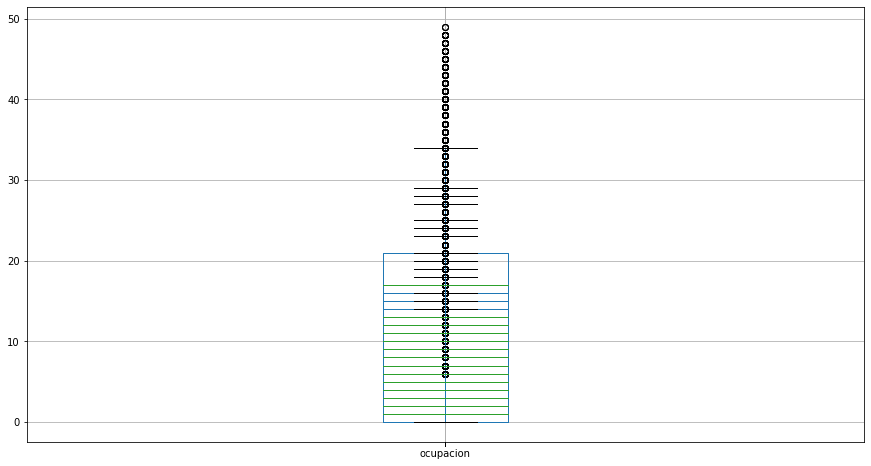

In [30]:
total_correct_pred = 0
full_data_len = 0
full_conf_mat =  np.zeros((1, 2, 2))
index = 0

for i in dataset2019['id_cuadra'].drop_duplicates():
    
    naive_bayes_data_cuadra = dataset2019.loc[dataset2019['id_cuadra'] == i].copy()
    clear_output()

    index+=1
    display('Indice:', index)
                
    if len(naive_bayes_data_cuadra) > 10: #10 datos minimo para entrenar
        if not with_outliers:
            max_without_outliers = naive_bayes_data_cuadra.boxplot(column='ocupacion', return_type='dict')['whiskers'][1].get_ydata()[1]
            naive_bayes_data_cuadra = naive_bayes_data_cuadra.loc[naive_bayes_data_cuadra['ocupacion'] <= max_without_outliers]

        data = naive_bayes_data_cuadra[['mes', 'dia de la semana', 'ocupacion', 'operacion', 'porcentaje ocupacion']]
        #x = data[['mes', 'dia de la semana', 'porcentaje ocupacion']].to_numpy()[:-1]
        x = data[['porcentaje ocupacion']].to_numpy()[:-1]
        y = data['operacion'].to_numpy()[1:]

        if (sum(y == 0) > 2) & (sum(y == 1) > 2):

            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, stratify=y)

            model = MultinomialNB()

            model.fit(x_train, y_train)

            predicts = model.predict(x_test)

            correct_values = predicts == y_test
            correct_values = sum(correct_values)

            full_data_len += len(predicts)

            total_correct_pred += correct_values

            full_conf_mat += confusion_matrix(y_test, predicts)

clear_output()

In [31]:
total_prob = (total_correct_pred / full_data_len)
full_conf_mat = (full_conf_mat)

In [32]:
print('Accuracy:        ', total_prob)
print('Confusion matrix:')
print(full_conf_mat)
print('')
print('Len(data):', full_data_len)

Accuracy:         0.5105624898908554
Confusion matrix:
[[[288786. 151082.]
  [278604. 159446.]]]

Len(data): 877918


## Modelo sin separar!

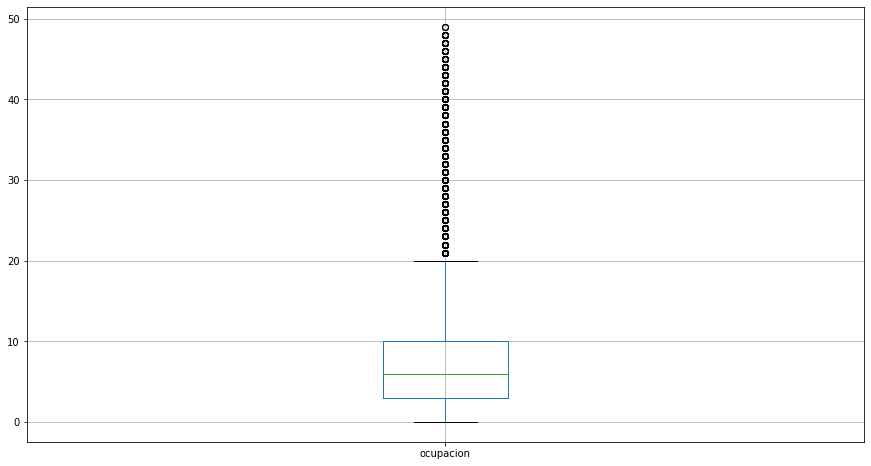

In [33]:
total_correct_pred = 0
full_data_len = 0
full_conf_mat =  0
index = 0

naive_bayes_data = dataset2019.copy()
if not with_outliers:

    max_without_outliers = naive_bayes_data.boxplot(column='ocupacion', return_type='dict')['whiskers'][1].get_ydata()[1]
    naive_bayes_data = naive_bayes_data.loc[naive_bayes_data['ocupacion'] <= max_without_outliers]

data = naive_bayes_data[['mes', 'dia de la semana', 'ocupacion', 'porcentaje ocupacion', 'operacion']]
#x = data[['mes', 'dia de la semana', 'porcentaje ocupacion']].to_numpy()[:-1]
x = data[['porcentaje ocupacion']].to_numpy()[:-1]
y = data['operacion'].to_numpy()[1:]

if (sum(y == 0) > 2) & (sum(y == 1) > 2):

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, stratify=y)

    model = MultinomialNB()

    model.fit(x_train, y_train)

    predicts = model.predict(x_test)

    correct_values = predicts == y_test
    correct_values = sum(correct_values)

    full_data_len = len(predicts)

    total_correct_pred = correct_values

    full_conf_mat = confusion_matrix(y_test, predicts)

clear_output()

In [34]:
total_prob = (total_correct_pred / full_data_len)
full_conf_mat = (full_conf_mat)

In [35]:
print('Accuracy:        ', total_prob)
print('Confusion matrix:')
print(full_conf_mat)
print('')
print('Len(data):', full_data_len)

Accuracy:         0.5011549684370041
Confusion matrix:
[[435214      0]
 [433208      0]]

Len(data): 868422


.

.

# Por que sabemos que no posee distribucion gaussiana y analisis de distribucion de los datos

In [50]:
naive_bayes_data = dataset2019.loc[dataset2019['direccion'] == 'Sarmiento 755'].reset_index(drop=True)

dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])

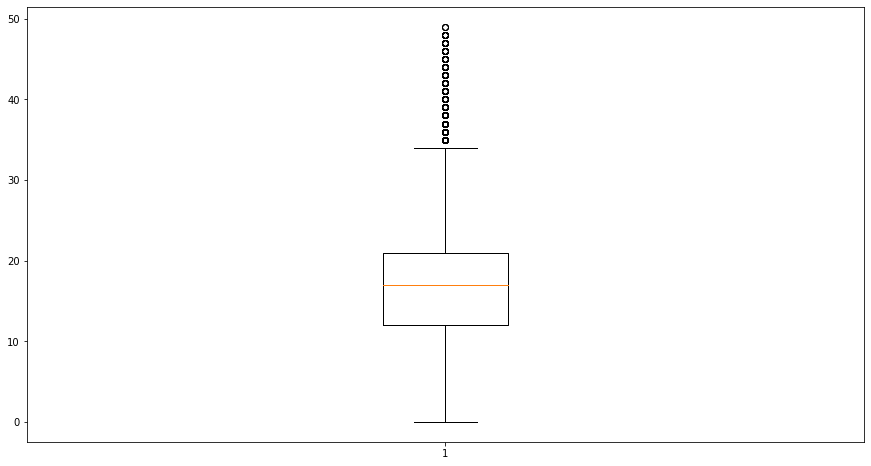

In [51]:
bp = plt.boxplot(naive_bayes_data['ocupacion'])
bp.keys()

In [52]:
max_without_outliers = bp['whiskers'][1].get_ydata()[1]
max_without_outliers

34.0

In [53]:
naive_bayes_data_without_outliers = naive_bayes_data.loc[naive_bayes_data['ocupacion'] <= max_without_outliers]
naive_bayes_data_without_outliers

dataset2019,id_cuadra,direccion,fecha,tiempo,operacion,ocupacion,latitud,longitud,dia de la semana,porcentaje ocupacion,mes,hora
0,32,Sarmiento 755,2019-01-02,05:58:00,1,1,-37.323840,-59.134883,2,0,1,5
1,32,Sarmiento 755,2019-01-02,07:34:00,1,2,-37.323405,-59.135455,2,0,1,7
2,32,Sarmiento 755,2019-01-02,07:49:00,1,3,-37.323405,-59.135455,2,0,1,7
3,32,Sarmiento 755,2019-01-02,08:20:00,1,4,-37.323405,-59.135455,2,0,1,8
4,32,Sarmiento 755,2019-01-02,09:08:00,1,5,-37.323405,-59.135455,2,0,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...
59089,32,Sarmiento 755,2019-12-31,14:35:00,1,8,-37.324370,-59.135207,1,1,12,14
59090,32,Sarmiento 755,2019-12-31,16:14:00,0,7,-37.324370,-59.135207,1,1,12,16
59091,32,Sarmiento 755,2019-12-31,16:34:00,0,6,-37.324370,-59.135207,1,1,12,16
59092,32,Sarmiento 755,2019-12-31,18:18:00,1,7,-37.324370,-59.135207,1,1,12,18


16.880393948624224

7.379050440250609

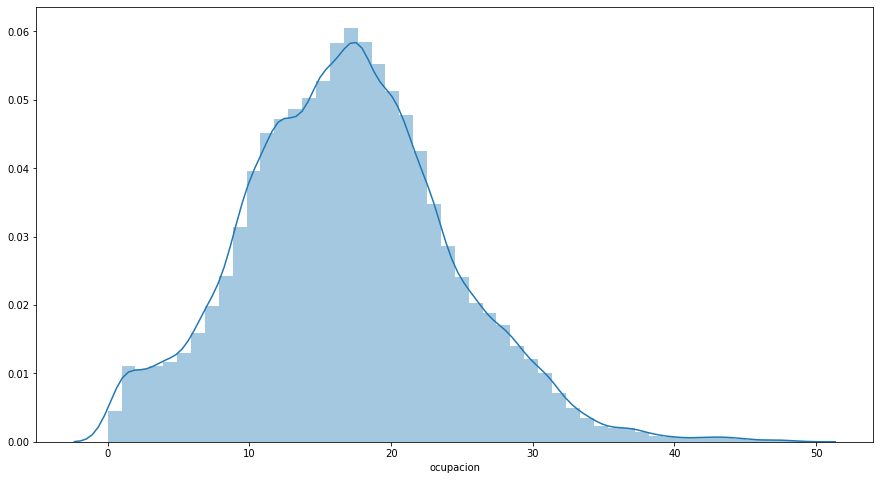

In [54]:
#Distribucion con valores atípicos

display(naive_bayes_data['ocupacion'].mean())
display(naive_bayes_data['ocupacion'].std())
sns.distplot(naive_bayes_data['ocupacion'])

16.588734567901234

6.964715236899148

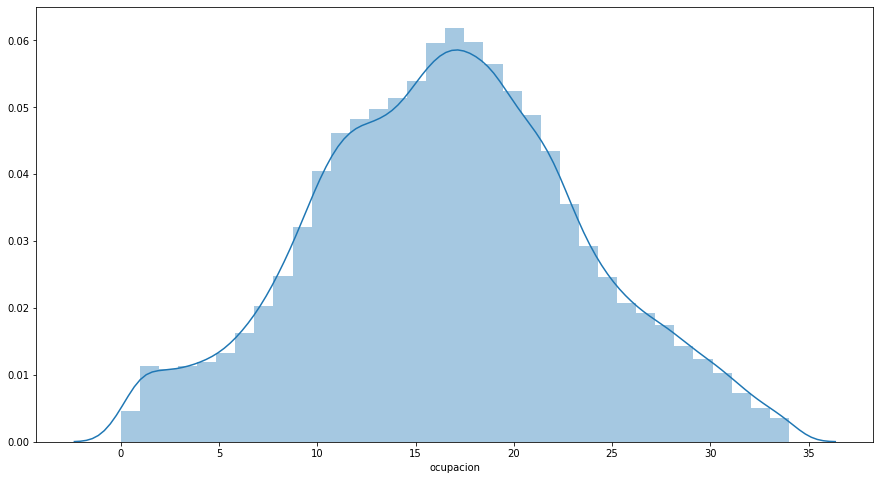

In [55]:
#Distribucion sin valores atípicos
display(naive_bayes_data_without_outliers['ocupacion'].mean())
display(naive_bayes_data_without_outliers['ocupacion'].std())
sns.distplot(naive_bayes_data_without_outliers['ocupacion'], bins=35)

In [56]:
naive_bayes_data_without_outliers

dataset2019,id_cuadra,direccion,fecha,tiempo,operacion,ocupacion,latitud,longitud,dia de la semana,porcentaje ocupacion,mes,hora
0,32,Sarmiento 755,2019-01-02,05:58:00,1,1,-37.323840,-59.134883,2,0,1,5
1,32,Sarmiento 755,2019-01-02,07:34:00,1,2,-37.323405,-59.135455,2,0,1,7
2,32,Sarmiento 755,2019-01-02,07:49:00,1,3,-37.323405,-59.135455,2,0,1,7
3,32,Sarmiento 755,2019-01-02,08:20:00,1,4,-37.323405,-59.135455,2,0,1,8
4,32,Sarmiento 755,2019-01-02,09:08:00,1,5,-37.323405,-59.135455,2,0,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...
59089,32,Sarmiento 755,2019-12-31,14:35:00,1,8,-37.324370,-59.135207,1,1,12,14
59090,32,Sarmiento 755,2019-12-31,16:14:00,0,7,-37.324370,-59.135207,1,1,12,16
59091,32,Sarmiento 755,2019-12-31,16:34:00,0,6,-37.324370,-59.135207,1,1,12,16
59092,32,Sarmiento 755,2019-12-31,18:18:00,1,7,-37.324370,-59.135207,1,1,12,18


In [57]:
#Si p es relativamente alto (> 0.5) estamos frente a una distribucion normal
k2, p = normaltest(naive_bayes_data_without_outliers[['mes', 'dia de la semana', 'hora', 'ocupacion']])
print(k2, p)

[50066.65829083 32770.97620923  7362.36859381   313.99544927] [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.55774491e-69]


((array([-4.22616911, -4.02203067, -3.91079749, ...,  3.91079749,
          4.02203067,  4.22616911]),
  array([ 0,  0,  0, ..., 34, 34, 34], dtype=int64)),
 (6.944874792931145, 16.58873456790123, 0.997088103798906))

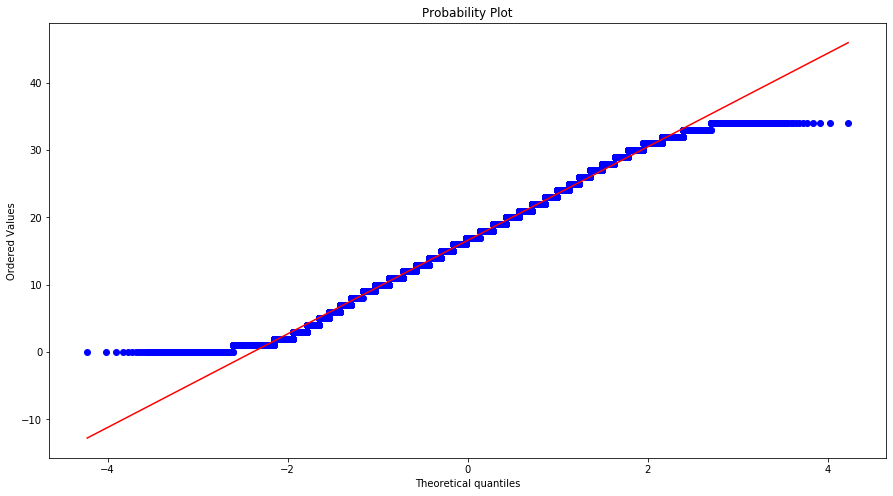

In [58]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
probplot(naive_bayes_data_without_outliers['ocupacion'], plot=ax1)

In [59]:
normalized_naive_bayes_data = naive_bayes_data_without_outliers['ocupacion'] + 1
normalized_naive_bayes_data = boxcox(normalized_naive_bayes_data)
normalized_naive_bayes_data

(array([0.97239762, 1.9084234 , 2.82158493, ..., 5.47440083, 6.33814403,
        5.47440083]), 0.9272731011403226)

In [60]:
k2, p = normaltest(normalized_naive_bayes_data[0])
print(k2, p)

274.29503432192945 2.738987752306982e-60


((array([-4.22616911, -4.02203067, -3.91079749, ...,  3.91079749,
          4.02203067,  4.22616911]),
  array([ 0.        ,  0.        ,  0.        , ..., 28.06663902,
         28.06663902, 28.06663902])),
 (5.677858749397844, 14.229333002332737, 0.9970493266902529))

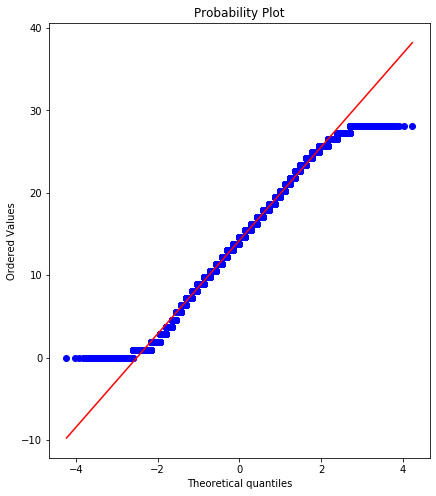

In [61]:
fig = plt.figure()
ax2 = fig.add_subplot(121)
probplot(normalized_naive_bayes_data[0], plot=ax2)

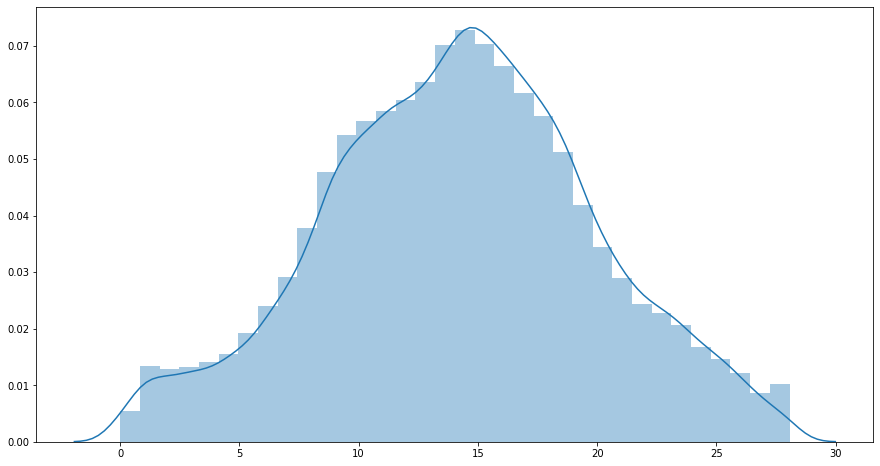

In [62]:
sns.distplot(normalized_naive_bayes_data[0], bins = 34)

In [63]:
gc.collect()

9859